## Classify Radio Signals from Space using Keras

In this experiment, we attempt to classify radio signals from space.

Dataset has been provided by SETI. Details can be found here:
https://github.com/setiQuest/ML4SETI/blob/master/tutorials/Step_1_Get_Data.ipynb


## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import tensorflow as tf

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Mount google drive to get data
from google.colab import drive
drive.mount('/content/drive')

!ls -l '/content/drive/My Drive/datasets/seti'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
total 8
drwx------ 2 root root 4096 Aug 20 18:37 train
drwx------ 2 root root 4096 Aug 20 18:37 validation


## Load data

In [ ]:
# Load dataset from CSV
train_images = pd.read_csv('/content/drive/My Drive/datasets/seti/train/images.csv', header=None)
train_labels = pd.read_csv('/content/drive/My Drive/datasets/seti/train/labels.csv', header=None)
val_images = pd.read_csv('/content/drive/My Drive/datasets/seti/validation/images.csv', header=None)
val_labels = pd.read_csv('/content/drive/My Drive/datasets/seti/validation/labels.csv', header=None)

In [ ]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,0.729412,0.725490,0.619608,0.674510,0.643137,0.705882,0.713726,0.658824,0.615686,0.690196,0.654902,0.525490,0.556863,0.541176,0.482353,0.588235,0.615686,0.600000,0.603922,0.627451,0.678431,0.658824,0.698039,0.576471,0.678431,0.686275,0.690196,0.705882,0.705882,0.643137,...,0.650980,0.666667,0.666667,0.709804,0.682353,0.682353,0.682353,0.658824,0.682353,0.643137,0.627451,0.623529,0.650980,0.721569,0.627451,0.635294,0.709804,0.690196,0.678431,0.647059,0.658824,0.682353,0.654902,0.694118,0.741176,0.678431,0.662745,0.729412,0.694118,0.647059,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,0.678431,0.709804,0.713726,0.686275,0.717647,0.713726,0.694118,0.690196,0.721569,0.701961,0.698039,0.713726,0.705882,0.756863,0.756863,0.694118,0.650980,0.674510,0.752941,0.725490,0.725490,0.760784,0.678431,0.717647,0.725490,0.682353,0.709804,0.729412,0.721569,0.717647,...,0.686275,0.670588,0.713726,0.733333,0.725490,0.694118,0.694118,0.686275,0.674510,0.729412,0.721569,0.701961,0.682353,0.709804,0.756863,0.698039,0.729412,0.721569,0.674510,0.698039,0.725490,0.733333,0.666667,0.682353,0.701961,0.737255,0.745098,0.725490,0.698039,0.650980,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,0.690196,0.670588,0.662745,0.666667,0.713726,0.701961,0.721569,0.713726,0.662745,0.698039,0.682353,0.639216,0.717647,0.658824,0.674510,0.639216,0.643137,0.635294,0.654902,0.682353,0.639216,0.733333,0.690196,0.658824,0.686275,0.658824,0.690196,0.698039,0.709804,0.650980,...,0.533333,0.572549,0.537255,0.549020,0.670588,0.690196,0.670588,0.643137,0.662745,0.713726,0.717647,0.721569,0.709804,0.674510,0.709804,0.686275,0.658824,0.694118,0.698039,0.694118,0.678431,0.678431,0.690196,0.662745,0.650980,0.650980,0.686275,0.631373,0.666667,0.701961,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,0.631373,0.650980,0.670588,0.737255,0.674510,0.615686,0.670588,0.705882,0.686275,0.678431,0.694118,0.647059,0.662745,0.682353,0.654902,0.721569,0.709804,0.631373,0.670588,0.674510,0.701961,0.725490,0.666667,0.647059,0.733333,0.682353,0.678431,0.603922,0.666667,0.713726,...,0.670588,0.705882,0.749020,0.662745,0.564706,0.623529,0.674510,0.709804,0.658824,0.631373,0.705882,0.670588,0.658824,0.690196,0.674510,0.658824,0.635294,0.682353,0.682353,0.639216,0.666667,0.654902,0.647059,0.670588,0.682353,0.639216,0.705882,0.729412,0.674510,0.666667,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,0.631373,0.709804,0.694118,0.698039,0.666667,0.690196,0.690196,0.682353,0.682353,0.647059,0.678431,0.658824,0.760784,0.729412,0.674510,0.694118,0.698039,0.713726,0.690196,0.698039,0.686275,0.705882,0.662745,0.670588,0.705882,0.682353,0.690196,0.733333,0.709804,0.701961,...,0.639216,0.690196,0.662745,0.658824,0.662745,0.698039,0.603922,0.690196,0.627451,0.627451,0.654902,0.725490,0.650980,0.717647,0.666667,0.709804,0.682353,0.674510,0.721569,0.741176,0.635294,0.615686,0.674510,0.690196,0.658824,0.694118,0.701961,0.670588,0.721569,0.780392,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [ ]:
train_labels.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [ ]:
# Check shape of train_images, train_labels, val_images nad val_labels

print("train_images shape:", train_images.shape)
print("train_labels shape:", train_labels.shape)

print("val_images shape:", val_images.shape)
print("val_labels shape:", val_labels.shape)

train_images shape: (3200, 8192)
train_labels shape: (3200, 4)
val_images shape: (800, 8192)
val_labels shape: (800, 4)


In [ ]:
# Reshape the image sets
# Get the values as numpy array

x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

## Plot 2D spectrogram data

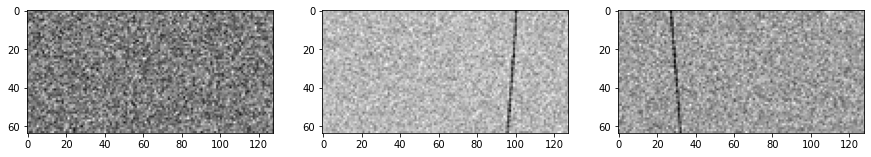

In [ ]:
plt.figure(figsize=(15,15))

for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[np.random.randint(x_train.shape[0])])
    plt.imshow(img, cmap='gray')

## Preprocess data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

## Build model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation 

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# Initialize model
model = Sequential()

# 1st CNN block
model.add(Conv2D(32, (5,5), padding='same', input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd CNN block
model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Falatter CNN output to feed to FC layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Softmax layer
model.add(Dense(4, activation='softmax'))

## Compile the model

In [ ]:
# Schedule learnning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.005,
    decay_steps=5,
    decay_rate=0.9,
    staircase=True)

In [ ]:
model.compile(optimizer=Adam(lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

## Train the model

In [ ]:
batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=10,
)

Epoch 1/10
100/100 [==============================] - 115s 1s/step - loss: 0.5255 - accuracy: 0.7044 - val_loss: 5.4126 - val_accuracy: 0.2500
Epoch 2/10
100/100 [==============================] - 118s 1s/step - loss: 0.4004 - accuracy: 0.7391 - val_loss: 6.4884 - val_accuracy: 0.2500
Epoch 3/10
100/100 [==============================] - 115s 1s/step - loss: 0.3882 - accuracy: 0.7412 - val_loss: 5.6150 - val_accuracy: 0.2675
Epoch 4/10
100/100 [==============================] - 115s 1s/step - loss: 0.3914 - accuracy: 0.7409 - val_loss: 4.6394 - val_accuracy: 0.4913
Epoch 5/10
100/100 [==============================] - 115s 1s/step - loss: 0.3956 - accuracy: 0.7456 - val_loss: 4.2016 - val_accuracy: 0.5000
Epoch 6/10
100/100 [==============================] - 114s 1s/step - loss: 0.3904 - accuracy: 0.7416 - val_loss: 3.1053 - val_accuracy: 0.5013
Epoch 7/10
100/100 [==============================] - 118s 1s/step - loss: 0.3828 - accuracy: 0.7378 - val_loss: 1.6581 - val_accuracy: 0.4963

## Evaluation

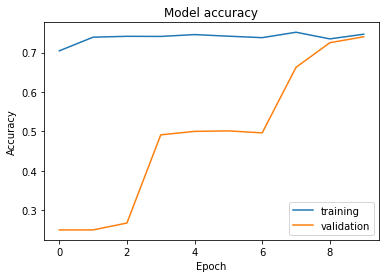

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])
plt.show()

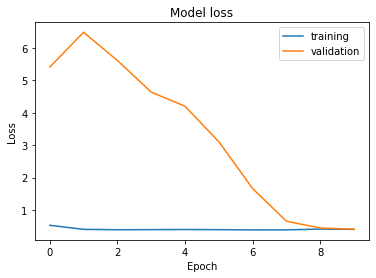

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'])
plt.show()

In [ ]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 6s 235ms/step - loss: 0.4045 - accuracy: 0.7462


[0.4044828712940216, 0.7462499737739563]

In [ ]:
y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)

print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %.2f" % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       200
           1       0.50      0.88      0.64       200
           2       0.54      0.15      0.23       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.76      0.75      0.71       800
weighted avg       0.76      0.75      0.71       800

Classification accuracy: 0.75


[Text(0, 0.5, 'squiggle'),
 Text(0, 1.5, 'narrowband'),
 Text(0, 2.5, 'noise'),
 Text(0, 3.5, 'narrowbanddrd')]

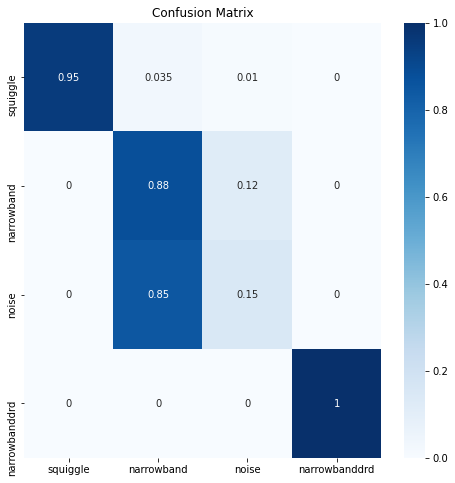

In [ ]:
plt.figure(figsize=(8,8))

labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax = plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax=ax, cmap=plt.cm.Blues)

ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## Conclusions

Winning submission has used ResNet based architechure (WRN) on primary (full) dataset, and achieved a classification accuracy of 94.99%.
Reference: https://github.com/sgrvinod/Wide-Residual-Nets-for-SETI

Here we have used a simple CNN based model. The model did not learn much after the first 2 epochs (accuracy is around 74% after 10 epochs).

Reasons:

*   The signals in the dataset have a noise factor added to it.
*   Even though the dataset, we have used here, is simpler than the other datasets provided by SETI, it's a bit challenging to extract features using a simple model like ours. So it is essentially a underfitting problem.

Possible improvements:

* Add additional CNN blocks, change filter sizes (e.g. 7x7, 5x5 etc.) to learn more features.
* Add additional fully connected layers.
* Here we have used Adam optimizer. It has convergence issues. We can change it SGD, and see what happens.
* Use a different architechture altogether.



